#**1.Import Libraries and load dataset**

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,confusion_matrix

from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
#load the dataset
df = pd.read_csv('/content/dataset(1).csv')
print("shape of the data:", df.shape)
df.head()

shape of the data: (45211, 11)


,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


# **2.Data Cleaning**

In [40]:
#check data types of all columns
df.dtypes

,0
age,int64
job,object
marital,object
education_qual,object
call_type,object
day,int64
mon,object
dur,int64
num_calls,int64
prev_outcome,object


**check missing data**

Handling missing data is a key stage in the preparation of data. Missing data refers to observations that are missing from columns. This can be due to partial results, inadequate information, or problems with data acquisition. Your machine learning model may make incorrect predictions or classifications if it receives missing data. Therefore, it's essential to find and address missing values.

In [41]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education_qual,0
call_type,0
day,0
mon,0
dur,0
num_calls,0
prev_outcome,0


In [42]:
df.duplicated().sum() #there are 6 duplicate rows we need to drop

6

In [43]:
df.drop_duplicates() #duplicated values dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45211 non-null  int64 
 1   job             45211 non-null  object
 2   marital         45211 non-null  object
 3   education_qual  45211 non-null  object
 4   call_type       45211 non-null  object
 5   day             45211 non-null  int64 
 6   mon             45211 non-null  object
 7   dur             45211 non-null  int64 
 8   num_calls       45211 non-null  int64 
 9   prev_outcome    45211 non-null  object
 10  y               45211 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.8+ MB


In [44]:
df.describe()       #statistically checking any outliers present or not

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


# **3.Exploratory Data Analysis**

**3.1 Dependent Variable**

In [45]:
df["y"].value_counts()

,count
y,
no,39922
yes,5289


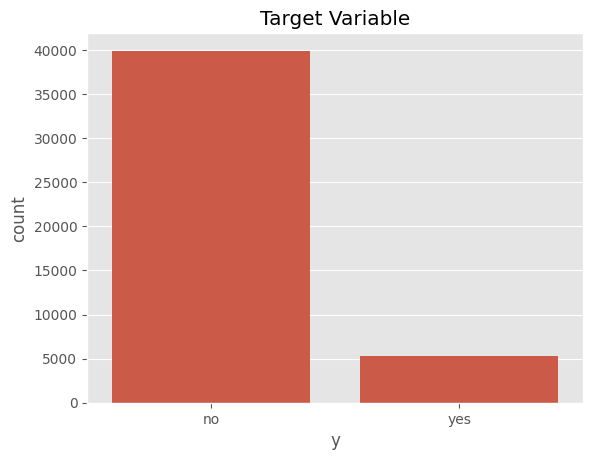

In [46]:
sns.countplot(x="y", data=df)
plt.title("Target Variable")
plt.show()

In [47]:
# percentage of class present in target variable(y)
print("percentage of NO and YES\n",df["y"].value_counts()/len(df)*100)

percentage of NO and YES
 y
no     88.30152
yes    11.69848
Name: count, dtype: float64


The target variable's class distribution is around 89:11, suggesting an imbalanced dataset.

**3.2 Univariate analysis of categorical variables**

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome',
       'y'],
      dtype='object')


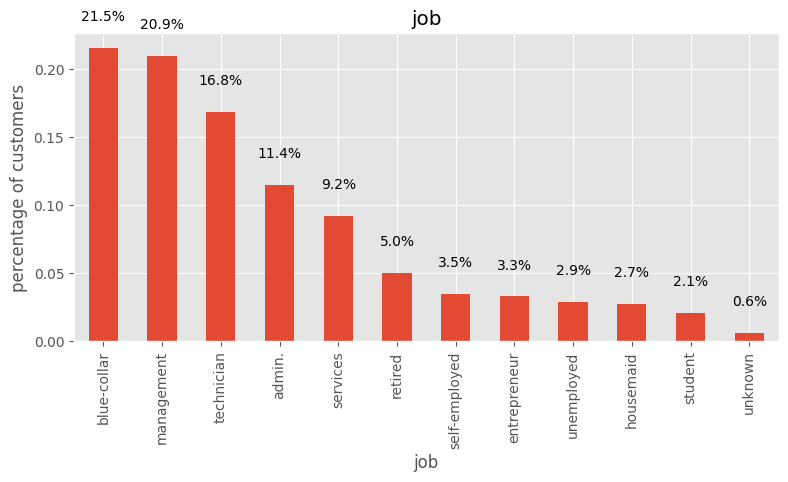

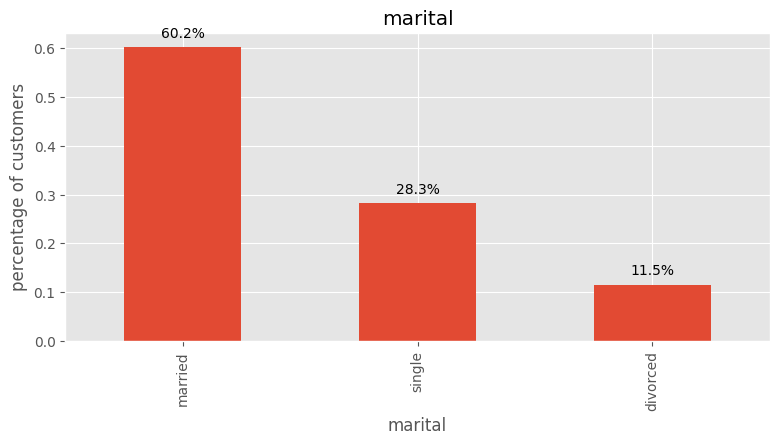

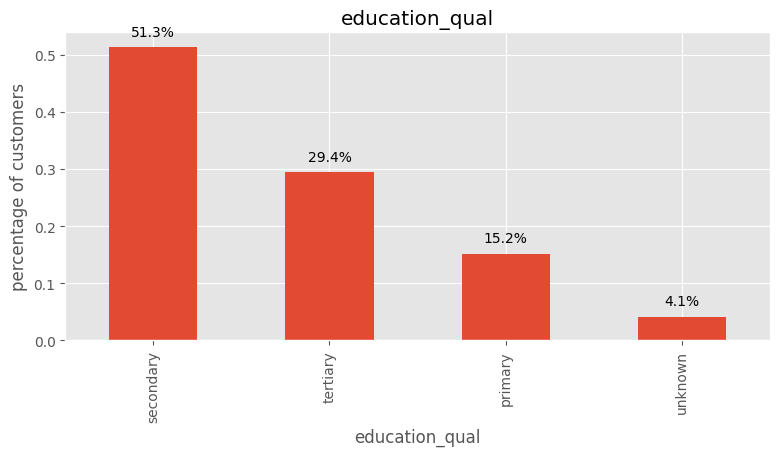

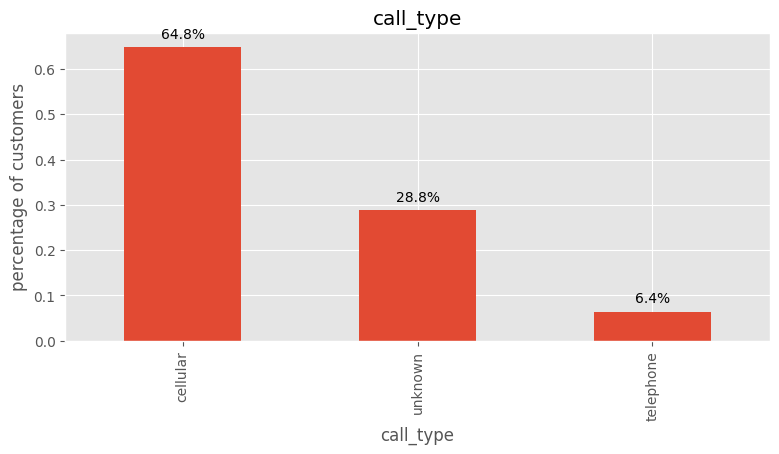

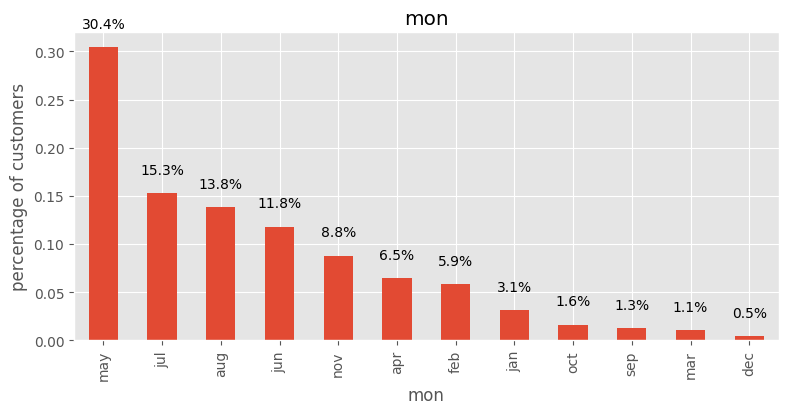

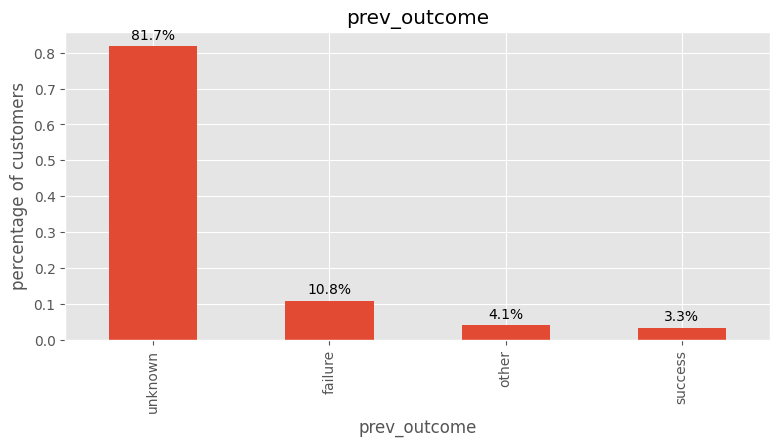

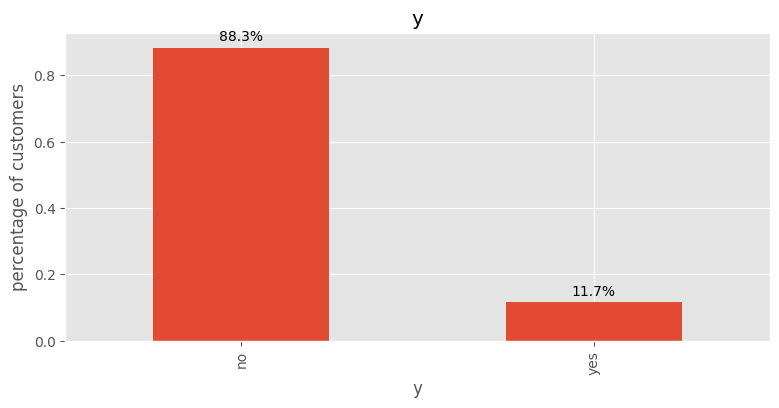

In [48]:
#identifying the categorical variables
cat_var = df.select_dtypes(include=["object"]).columns
print(cat_var)

#plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_var:
  plt.figure(figsize=(20,4))
  ax = plt.subplot(121)
  df[column].value_counts(normalize=True).plot(kind="bar")
  plt.xlabel(column)
  plt.ylabel("percentage of customers")
  plt.title(column)

  #Add percentage labels to the top of each bar
  for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.02, f"{p.get_height()*100:.1f}%", ha="center")

**Observations :**

Blue-collar vocations, technicians, and management are the top three professions among our clientele.

Several of the clients are married.

Customers primarily use the cellular type.

In May, a large number of clients were contacted.

There are very few clients that have successfully converted in the past.

The majority of clients hold a secondary education qualification.

The target variable exhibits a significant imbalance as seen by the graphic.

In several columns, the absent values have been indicated as unknown. Missing data is represented as unknown.




In [49]:
cate_var = ['job','education_qual']
for column in cate_var:
  mode = df[column].mode()[0]
  df[column] = df[column].replace("unknown", mode)

**3.3 Univariate analysis of Numerical columns**

In [50]:
#identifying the numerical variables
num_var = df.select_dtypes(include=np.number)
num_var.head()

,age,day,dur,num_calls
0,58,5,261,1
1,44,5,151,1
2,33,5,76,1
3,47,5,92,1
4,33,5,198,1


<ipython-input-51-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)
<ipython-input-51-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)
<ipython-input-51-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and 

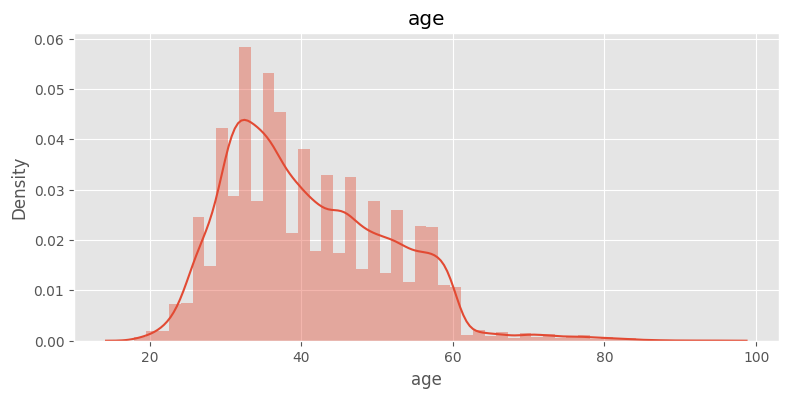

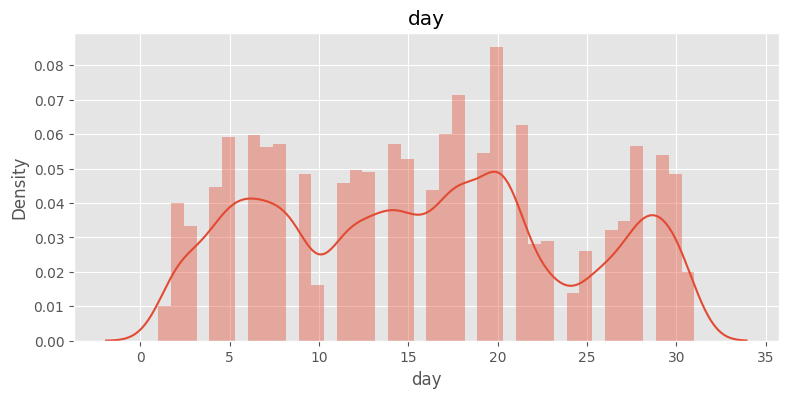

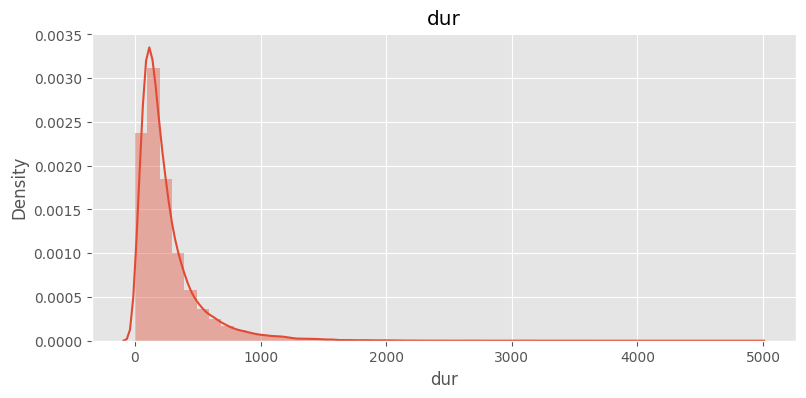

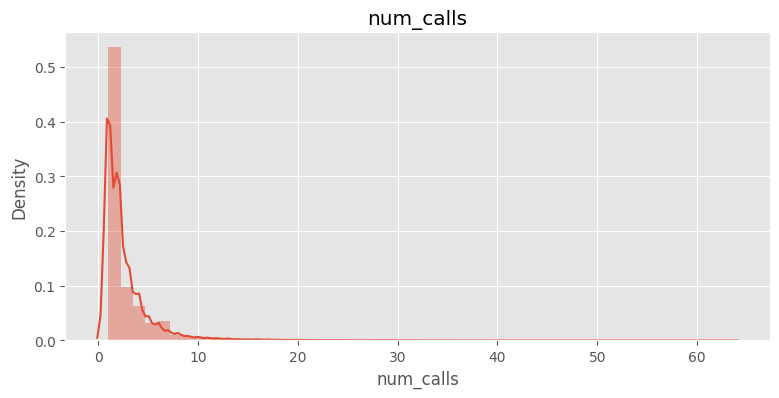

In [51]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "day", "dur",'num_calls']:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(df[column], kde=True)
    plt.title(column)

**Observation :**

The features age, dur, and num calls are highly skewed, as the histogram illustrates, and this is because these characteristics include outliers, as the boxplot for these features demonstrates.

The majority of the clients were being contacted for the first or second time, based on the plot for num_calls.


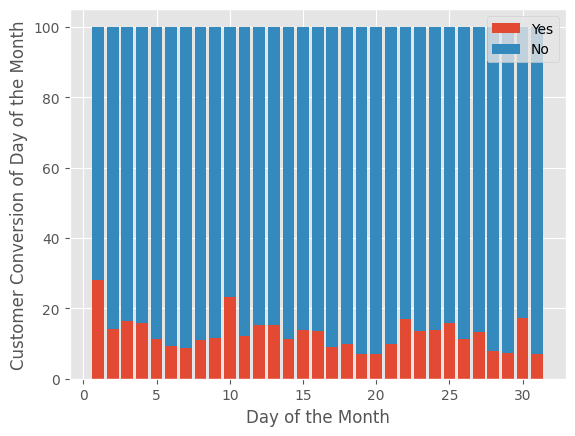

In [52]:
day_counts = df.groupby('day')['y'].value_counts(normalize=True) * 100
yes_counts = day_counts[:, 'yes']
no_counts = day_counts[:, 'no']

plt.bar(day_counts.index.levels[0], yes_counts, label="Yes")
plt.bar(day_counts.index.levels[0], no_counts, bottom=yes_counts, label="No")
plt.xlabel('Day of the Month')
plt.ylabel('Customer Conversion of Day of the Month')
plt.legend()
plt.show()

 **Observation**

The accompanying plot shows that the majority of customers replied yes on dates 1, 10, and 30.

# **4.Bivariate Analysis of Categorical Columns**

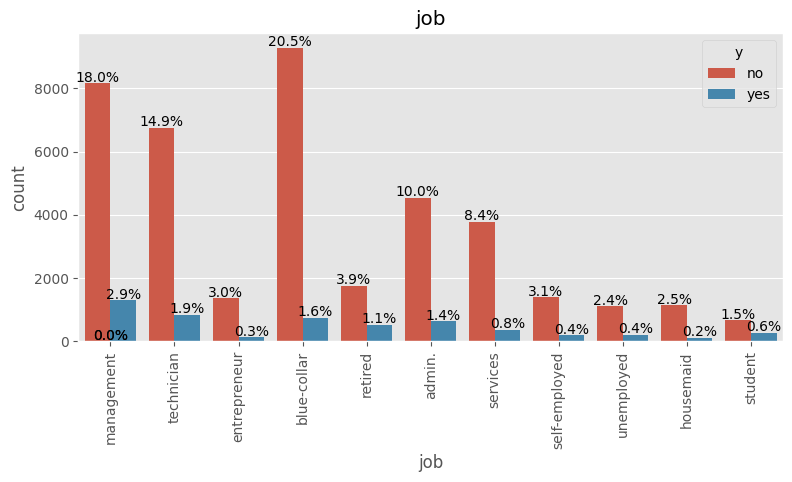

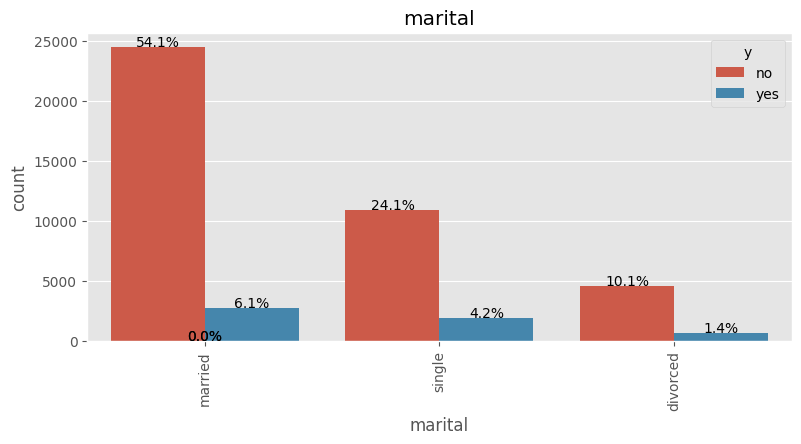

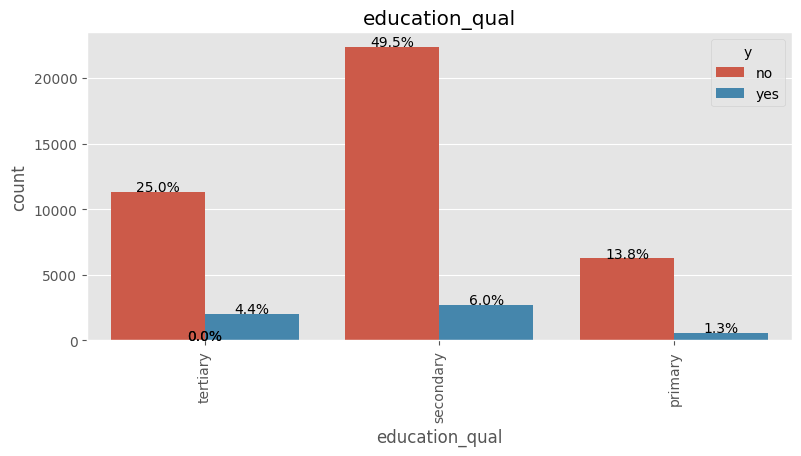

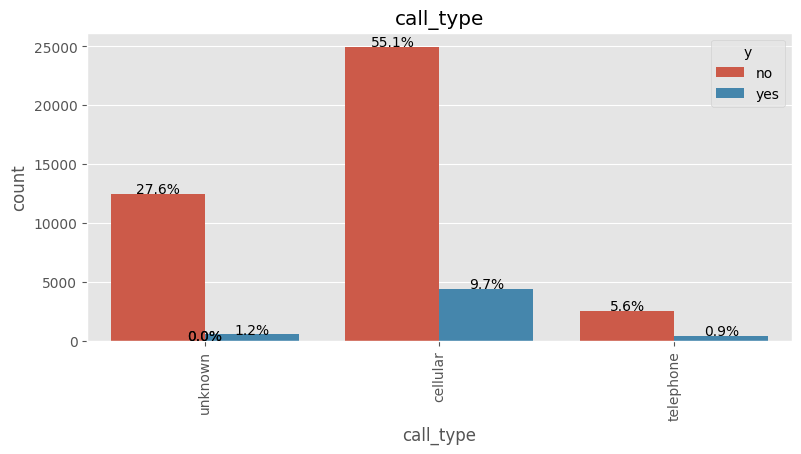

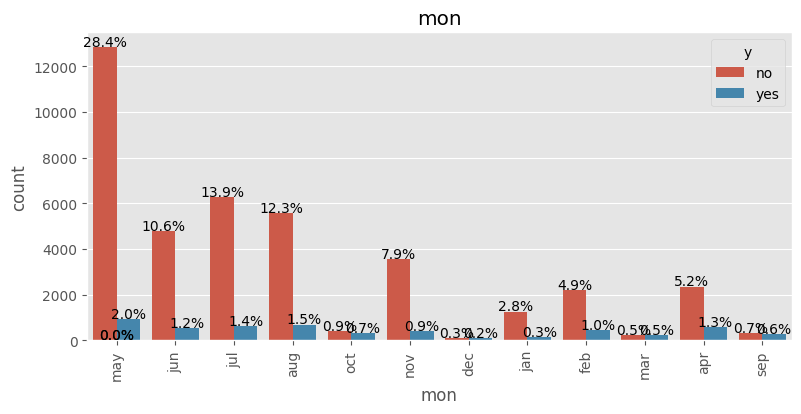

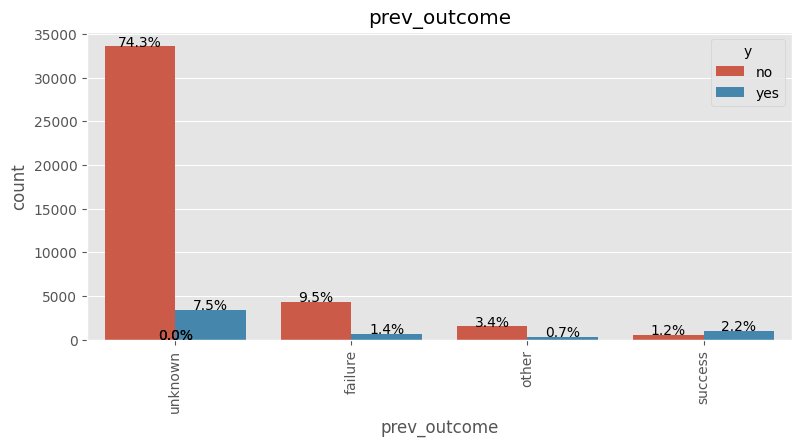

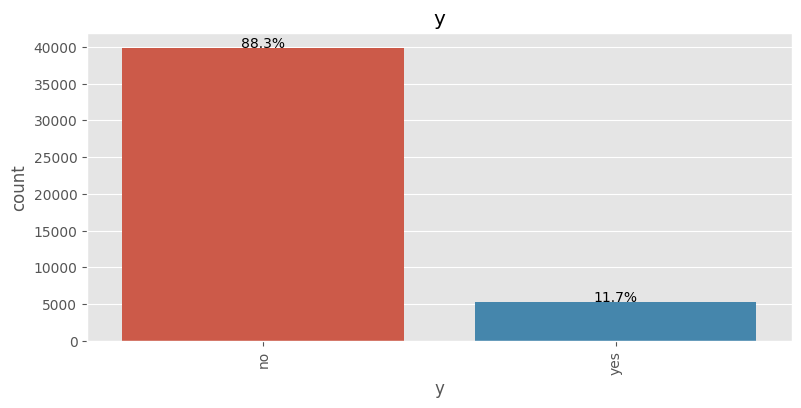

In [53]:
plt.style.use("ggplot")

for column in cat_var:
  plt.figure(figsize=(20,4))
  ax = plt.subplot(121)
  sns.countplot(x=column, hue="y", data=df)
  plt.title(column)
  plt.xticks(rotation=90)

  #Add percentage labels to the top of each bar
  for p in ax.patches:
    height = p.get_height()
    total = sum([p.get_height() for p in ax.patches if p.get_x() == p.get_x()])
    ax.text(p.get_x()+p.get_width()/2., height+50, f"{height/total*100:.1f}%", ha="center")

  plt.show()

**Observations:**

1.The majority of customers who have successfully converted hold management positions.

2.Most of the individuals who converted are married.

3.Individuals with secondary education qualifications have the highest conversion rates.

4.Cell phones should be the primary means of reaching out to customers.

5.May should be the favored month for making contact.



# **5.Handling Outliers**

Outliers have a considerable effect on the mean and variance, making it essential to address them.

In [54]:
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


In [55]:
#compute interquantile range to calculate the boundaries
lower_boundaries = []
upper_boundaries = []

for i in ["age", "dur", "day", "num_calls"]:
  IQR = df[i].quantile(0.75) - df[i].quantile(0.25)
  lower_bound = df[i].quantile(0.25) - (1.5*IQR)
  upper_bound = df[i].quantile(0.75) + (1.5*IQR)

  print(i, ":", lower_bound, ",", upper_bound)

  lower_boundaries.append(lower_bound)
  upper_boundaries.append(upper_bound)

age : 10.5 , 70.5
dur : -221.0 , 643.0
day : -11.5 , 40.5
num_calls : -2.0 , 6.0


In [56]:
#replace all the outliers which is greater than upper boundary by upper boundary
j = 0
for i in ["age", "dur", "day", "num_calls"]:
  df.loc[df[i] > upper_boundaries[j], i] = int(upper_boundaries[j])
  j = j+1

Since the lower boundary for age (10.5) is less than the minimum value (18), and the lower boundaries for duration, number of calls, and day are negative (-221.0, -11.0, and -2.0 respectively), it is unnecessary to replace the outliers with the lower boundary.

In [57]:
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.862799,15.806419,234.939307,2.392228
std,10.379659,8.322476,176.749932,1.600111
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,70.000000,31.000000,643.000000,6.000000


**After substituting the outliers with the upper boundary, the maximum values have been adjusted without affecting other parameters such as the mean, standard deviation, and quartiles.**

**4.Encoding Categorical Features**

In [58]:
#'y' target variable
df.replace({'y' : { 'yes' : 1, 'no' : 0}},inplace=True)

<ipython-input-58-a2435a5aacf3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'y' : { 'yes' : 1, 'no' : 0}},inplace=True)


In [59]:
cat_var = df.select_dtypes(include=["object"]).columns
print(cat_var)

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome'], dtype='object')


In [60]:
for i in cat_var:
  print(i, ":", df[i].unique())

job : ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
marital : ['married' 'single' 'divorced']
education_qual : ['tertiary' 'secondary' 'primary']
call_type : ['unknown' 'cellular' 'telephone']
mon : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
prev_outcome : ['unknown' 'failure' 'other' 'success']


In [61]:
def encoding_data(df,col):
  for i in col:
    df_dummies = pd.get_dummies(df[i], prefix=i)
    df = pd.concat([df, df_dummies], axis=1)
    df.drop([i], inplace=True,axis=1)
  return df

In [62]:
columns = ['call_type', 'prev_outcome', 'marital', 'job']
df = encoding_data(df,columns)

In [63]:
#Months column
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['mon'] = df['mon'].apply(
    lambda x: months.index(x)+1
)

In [64]:
#'education_qual'
df.replace({'education_qual' : { 'tertiary' : 1, 'secondary' : 2, 'primary' : 3}},inplace=True)

<ipython-input-64-00ffc1701613>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'education_qual' : { 'tertiary' : 1, 'secondary' : 2, 'primary' : 3}},inplace=True)


**Oberservation**

After experimenting with the XGBoost model, I found that using label encoding for the job feature results in an AUROC score of 0.969, while one-hot encoding yields a score of 0.986. Therefore, we will use one-hot encoding.

**Checking Correlation of feature variables**

**There are no features that exhibit high positive or negative correlations. If such features existed, we could have established a condition to drop them if their correlation exceeded 0.8 (or any threshold value based on domain knowledge) or fell below -0.8, as these correlated features would essentially serve the same purpose.**

# **5.Split Dataset**

**Separating independent and dependent variables**

In [65]:
p = df.drop(['y'],axis=1)
q = df['y']

**Given that the class distribution in the target variable is approximately 89:11, indicating an imbalanced dataset, we need to perform resampling.**

**SMOTE Oversampling we are using due to imbalance data**

In [66]:
#Define the SMOTETomek object with a 0.75 sampling strategy
smote_tomek = SMOTETomek(sampling_strategy=0.75)

#Apply SMOTETomek oversampling to the training data
X, y = smote_tomek.fit_resample(p,q)

#Check the class distribution of the resampled data
print(y.value_counts())

y
0    39502
1    29521
Name: count, dtype: int64


Splitting resampled data in train and test data

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# **6.Scaling**

In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **7.Models**

1.Logistic Regression

In [69]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)
predicted = lr_model.predict(X_test)
conf = confusion_matrix(y_test, predicted)

print()
print()
print("The accuracy of Logistic Regression is : ", accuracy_score(y_test, predicted)*100, "%")
print("The auroc_auc_score of Logistic Regression is : ", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))
log_reg_y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
log_reg_auc = roc_auc_score(y_test, log_reg_y_pred_prob)



The accuracy of Logistic Regression is :  91.88690842040566 %
The auroc_auc_score of Logistic Regression is :  0.9743573954190307


**2.Random Forest**

In [70]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
predicted = rf_model.predict(X_test)
print("The accuracy of Random Forest is : ", accuracy_score(y_test, predicted.round())*100, "%")
print("The auroc_auc_score of random forest is : ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
dt_y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_prob)
dt_auc = roc_auc_score(y_test, dt_y_pred_prob)

The accuracy of Random Forest is :  93.55079462639388 %
The auroc_auc_score of random forest is :  0.9852331688443378


**3.XGBOOST**

In [71]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_train, y_train)
predicted = xgb_model.predict(X_test)

print()
print("The accuracy of X Gradient Boosting is : ", accuracy_score(y_test, predicted)*100, "%")
print("The auroc_auc_score of Gradient Bossting is : ", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))
xgb_y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_y_pred_prob)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:18:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



The accuracy of X Gradient Boosting is :  93.23909035033805 %
The auroc_auc_score of Gradient Bossting is :  0.9851149002220836


**observations**

Using SMOTE for oversampling results in a higher AUROC score.

Without SMOTE, the AUROC scores for Logistic Regression, Random Forest, and XGBoost are 0.879, 0.919, and 0.927, respectively.

With SMOTE, the AUROC scores for Logistic Regression, Random Forest, and XGBoost improve to 0.975, 0.985, and 0.985.

# **7.Feature Importance**

<Axes: >

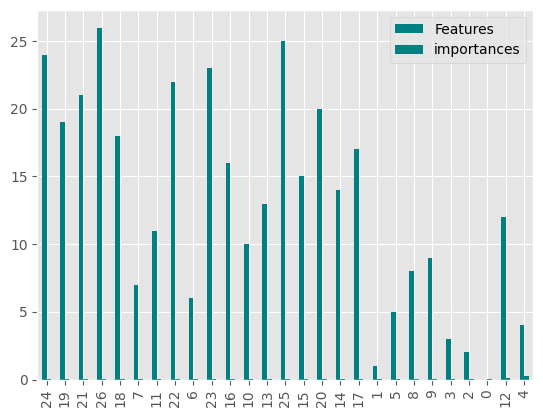

In [72]:
importances = rf_model.feature_importances_
df1 = pd.DataFrame({"Features":pd.DataFrame(X_test).columns, "importances":importances})
df1.set_index("importances")

df1 = df1.sort_values('importances')
df1.plot.bar(color='teal')

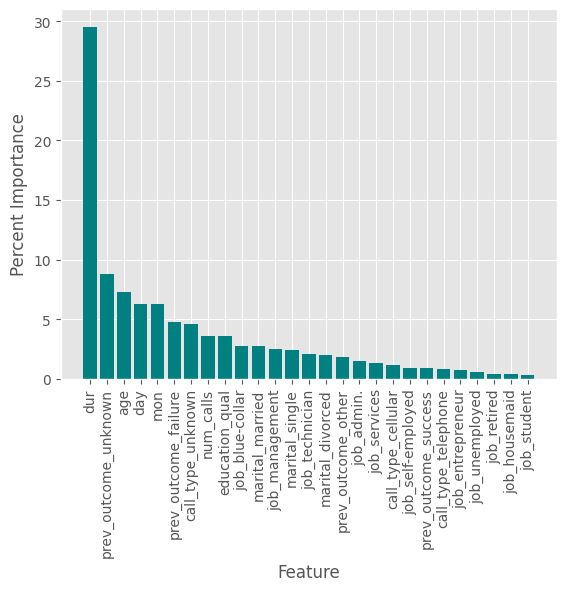

In [73]:
feature_names = list(df.columns)
if 'y' in feature_names:
  feature_names.remove('y')
total_importance = importances.sum()
percent_importances = importances / total_importance * 100

#create a DataFrame with the feature names and their percent importances
df = pd.DataFrame({'feature_names': feature_names, 'percent_importances': percent_importances})

#sort the DataFrame by percent importances in descending order
df = df.sort_values(by='percent_importances', ascending=False)

#Create a bar plot of the percent importances
plt.bar(x=df['feature_names'], height=df['percent_importances'], color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percent Importance')
plt.show()

**Most Important feature is duration**

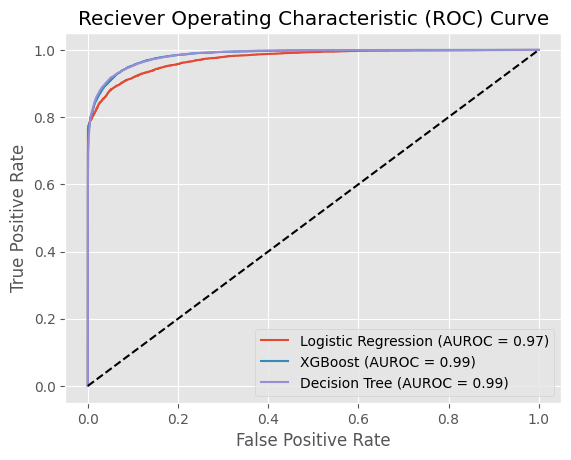

In [74]:
log_ref_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_y_pred_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_prob)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_prob)

#plot ROC curves
plt.plot(log_ref_fpr, log_reg_tpr, label=f'Logistic Regression (AUROC = {log_reg_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUROC = {xgb_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUROC = {dt_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# **Conclusion**




**According to the evaluation results of the three classification models (Logistic Regression, XGBoost, and Decision Tree Classifier) on the historical data, XGBoost achieved the highest accuracy score of 93.54% and an AUROC score of 0.986, surpassing the other models.**

**This indicates that XGBoost is an effective model for predicting whether a client will subscribe to the insurance. It is advisable to implement this model in a production environment to accurately identify potential customers and enhance marketing efficiency.**

**Nonetheless, additional analysis is suggested to pinpoint the key features influencing the model's performance and to optimize the model for improved results.**